# Statistical analysis of water discharge of surface streams

Large amounts of historical surface water data are available from the United States Geological Survey (USGS) at https://waterdata.usgs.gov/nwis The goal of the project is to retrieve samples from the web interface manually, and then later  automate the process by calling the web service as described at https://help.waterdata.usgs.gov/faq/automated-retrievals.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit

## Excercise 1

For the purposes of the current excercises, select a stream from a rainy area with relatively small discharge so that the effect of short but strong storms is visible. Good choices are small rivers from the north-eastern US, e.g. site 01589440. Retrieve at least 10 years of data.

In [2]:
data = pd.read_csv("water-01589440.txt", sep='\t', comment='#', header=0, skiprows=[0], parse_dates=[2])
data=data.rename(columns={'69744_00060':'Discharge'})
data=data.drop(0)
data=data.drop(data[data.Discharge.isna()].index)
data.Discharge=data.Discharge.astype(float)
data.datetime=pd.to_datetime(data.datetime)

# too long time interval:
data = data[data.datetime.apply(lambda x:x.year) < 2018]


data.head()

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (1,4,6) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,agency_cd,site_no,datetime,tz_cd,Discharge,69744_00060_cd,69745_00065,69745_00065_cd
1,USGS,01589440,2007-01-01 00:00:00,EST,18.0,A:[91],NaN,NaN
2,USGS,01589440,2007-01-01 00:15:00,EST,18.0,A:[91],NaN,NaN
3,USGS,01589440,2007-01-01 00:30:00,EST,18.0,A:[91],NaN,NaN
4,USGS,01589440,2007-01-01 00:45:00,EST,18.0,A:[91],NaN,NaN
5,USGS,01589440,2007-01-01 01:00:00,EST,18.0,A:[91],NaN,NaN


In [3]:
# data = pd.read_csv("water-01585500.txt", sep='\t', comment='#', header=0, skiprows=[30], parse_dates=[2])
# data=data.rename(columns={'69679_00060':'Discharge'})
# data=data.dropna()
# data.head()

## Excercise 2

Load the downloaded data file into the processing environment paying attention to handling time stamps and perfoming the necessary data type conversions. Converting dates to floating point numbers such as unix time stamp or julian date usually makes handling time series easier. Plot the data for a certain interval to show that the effect of storms is clearly visible.

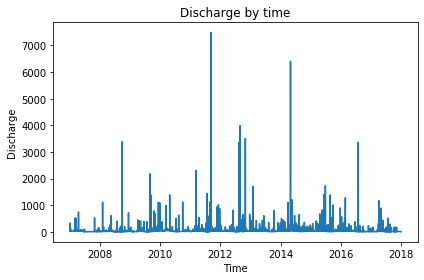

In [4]:
plt.plot(data.datetime,data.Discharge)
plt.xlabel('Time')
plt.ylabel('Discharge')
plt.title('Discharge by time')
# plt.yscale('log')
plt.tight_layout()

# Conclusion:

The peaks are the stormy periods.

## Excercise 3

Plot the histogram of water discharge values. Fit the data with an appropriate distribution function and bring arguments in favor of the choice of function.

In [13]:
discharges=list(data.Discharge)


Text(0, 0.5, 'Counter')

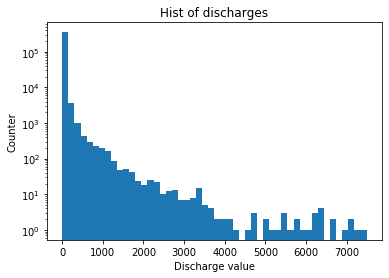

In [14]:
plt.hist(discharges,bins=50,log=True)
plt.title('Hist of discharges')
plt.xlabel('Discharge value')
plt.ylabel('Counter')

A gamma b
[ 1.23453757e+09  2.29471494e+00 -9.36321807e-01]
[5.38721976e+08 7.02893778e-02 3.37711147e+00]


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: overflow encountered in power
  


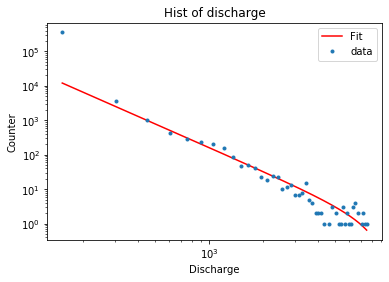

In [15]:
hist_d,bin_edges_d = np.histogram(discharges,bins=50)


def f_exp(x,A,b,c):
    return A*np.exp(-b*x)+c

def f_powerlaw(x,A,gamma,B):
    return A*x**(-gamma) + B
p0_my=[50000,3,1]


skip_point = 2
tt = np.linspace(min(bin_edges_d[1:]),max(discharges),300)

popt_d,pcov_d = curve_fit(f_powerlaw,bin_edges_d[skip_point+1:],hist_d[skip_point:],p0=p0_my)
perr_d = np.sqrt(np.diag(pcov_d))
print('A gamma b')
print(popt_d)
print(perr_d)
plt.plot(tt,f_powerlaw(tt,*popt_d),'r-',label='Fit')
plt.plot(bin_edges_d[1:],hist_d,'.',label='data')
plt.yscale('log')
plt.xscale('log')
plt.title('Hist of discharge')
plt.xlabel('Discharge')
plt.ylabel('Counter')
plt.legend()

# Conclusion:
We can see a distribution that follows a powerlaw. The greater discharge values are less likely, but there are some, more than what would come from an exponential distribution

## Excercise 4

In case of small streams, storms and passing weather fronts with rain can significantly increase water discharge on a short time scale. Develop a simple algorithm to detect rainy events in the data. Plot the original time series and mark rainy events.

In [16]:
rainy_start = []
rainy_end = []
rainy_length = []
def detect_rainy_events(data,crit_length = 5,crit_discharge=500):
    '''
    Detect those events, where the value of discharge is increasing in a row or its maximum value is greater than 
    a crit. value.
    Return the start and end of events.
    '''
    start_idxs = []
    end_idxs = []
    lengths = []
    for i in range(1,len(data)):
        length = 0
        start = i
        while data[i]>data[i-1]:
            length+=1
            i+=1
        end = i
        if start!=end:
            max_val = max(data[start:end])
        else:
            max_val = 0
        
        if length> crit_length or max_val > crit_discharge:
            start_idxs.append(start)
            end_idxs.append(end)
            lengths.append(length)
            
    return start_idxs,end_idxs,lengths
    
    
rainy_event_length = 20 # it's number of rainy events in a row
rainy_start,rainy_end,rainy_length = detect_rainy_events(discharges,crit_length=rainy_event_length)
middle_of_rainy_idx = [int(np.average([rainy_start[i],rainy_end[i]])) for i in range(len(rainy_start))]
rainy_peak_index = []
rainy_peak_max = []
for i in range(len(rainy_start)):
    rainy_peak_max.append(max(discharges[rainy_start[i]:rainy_end[i]]))
    rainy_peak_index.append(discharges.index(max(discharges[rainy_start[i]:rainy_end[i]])))
    

In [17]:
len(rainy_end)

2016

Text(0, 0.5, 'length of rainy time')

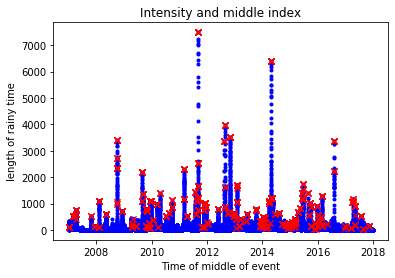

In [18]:
df_rainy = data.iloc[middle_of_rainy_idx,:]
rainy_datetime = list(df_rainy.datetime)

tt = [rainy_datetime for i in middle_of_rainy_idx]
plt.plot(data.datetime,data.Discharge,'b.',label='Data')

# plt.plot(df_rainy.datetime,rainy_length,'rx',label='Rainy')
plt.plot(df_rainy.datetime,rainy_peak_max,'rx',label='Rainy')

plt.title('Intensity and middle index')
plt.xlabel('Time of middle of event')
plt.ylabel('length of rainy time')

# Conclusion:
The algorithm gives us the start and end points of the storms, where the discharge values are increasing within a certain period or the max of value in the period is higher than a certain value. <br>
This isn't the best algorithm, but the it's based on the most impoertant quantities of a storm, its length and maximum discharge.

## Excercise 5

Water discharge increases significantly during rain producing maxima in the time series. Plot the distribution of maximum values and fit with an appropriate function. Bring arguments to support the choice of probabilistic model.

A gamma b
[ 1.82649651e+03  2.33990695e-01 -2.46689247e+02]
[1.12030254e+03 2.04613421e-01 2.87701337e+02]


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: overflow encountered in power
  


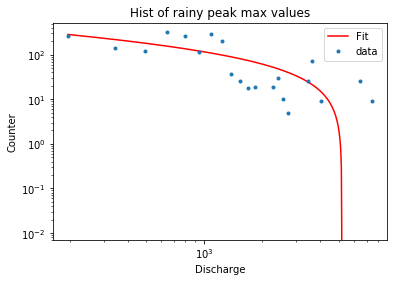

In [26]:
hist_r,bin_edges_r = np.histogram(rainy_peak_max,bins=50)


def f_exp(x,A,b,c):
    return A*np.exp(-b*x)+c

def f_powerlaw(x,A,gamma,B):
    return A*x**(-gamma) + B
p0_my=[240,1.5,1]


skip_point = 0
tt = np.linspace(min(bin_edges_r[1:]),max(bin_edges_r),300)

popt_r,pcov_r = curve_fit(f_powerlaw,bin_edges_r[skip_point+1:],hist_r[skip_point:],p0=p0_my)
perr_r = np.sqrt(np.diag(pcov_r))
print('A gamma b')
print(popt_r)
print(perr_r)
plt.plot(tt,f_powerlaw(tt,*popt_r),'r-',label='Fit')
plt.plot(bin_edges_r[1:],hist_r,'.',label='data')
plt.yscale('log')
plt.xscale('log')
plt.title('Hist of rainy peak max values')
plt.xlabel('Discharge')
plt.ylabel('Counter')
plt.legend()

# Conclusion:
We can see a distribution that follows a powerlaw. The greater maximums values are less likely, but there are some, more than what would come from an exponential distribution.

## Excercise 6

Once rainy events are detected, plot the distribution of the length of sunny intervals between rains. Fit the distribution with an appropriate function.

In [27]:
sunny_length = [int(rainy_end[i+1]-rainy_start[i]) for i in range(len(rainy_start)-1)]


A gamma b
[233.11710638   0.39306302  -5.69821914]
[2.12663282e+02 1.66982270e-01 4.04865575e+00]


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: overflow encountered in power
  


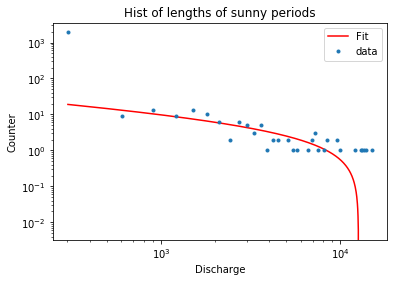

In [28]:
hist_s,bin_edges_s = np.histogram(sunny_length,bins=50)


def f_exp(x,A,b,c):
    return A*np.exp(-b*x)+c

def f_powerlaw(x,A,gamma,B):
    return A*x**(-gamma) + B




skip_point = 1
tt = np.linspace(min(bin_edges_s[1:]),max(bin_edges_s),300)

p0_my=[100,1.5,1]
popt_s,pcov_s = curve_fit(f_powerlaw,bin_edges_s[skip_point+1:],hist_s[skip_point:],p0=p0_my)
perr_s = np.sqrt(np.diag(pcov_s))
print('A gamma b')
print(popt_s)
print(perr_s)
plt.plot(tt,f_powerlaw(tt,*popt_s),'r-',label='Fit')
plt.plot(bin_edges_s[1:],hist_s,'.',label='data')
plt.yscale('log')
plt.xscale('log')
plt.title('Hist of lengths of sunny periods')
plt.xlabel('Discharge')
plt.ylabel('Counter')
plt.legend()

# Conclusion:
The sunny periods are between the last strom ending index and the next strom starting value.
Its distribution is similar to a powerlaw. So there are some long periods without rain.

## Excercise 7

What is the maximum of water discharge in an arbitrarily chosen period of one year? Calculate the maximum of water discharge due to rain in a rolling window of 1 year, plot its distribution and fit with an appropriate function.

In [22]:
data['year'] = data.datetime.apply(lambda x:x.year)
data['month'] = data.datetime.apply(lambda x:x.month)
data['day'] = data.datetime.apply(lambda x:x.day)

data_sub = data[['datetime','Discharge','year','month','day']]
data_sub.head()

,datetime,Discharge,year,month,day
1,2007-01-01 00:00:00,18.0,2007,1,1
2,2007-01-01 00:15:00,18.0,2007,1,1
3,2007-01-01 00:30:00,18.0,2007,1,1
4,2007-01-01 00:45:00,18.0,2007,1,1
5,2007-01-01 01:00:00,18.0,2007,1,1


A gamma b
[ 1.61667558e+03  7.37097194e-01 -3.30035484e+00]
[7.38258536e+02 8.90013550e-02 1.16612553e+00]


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in power
  # Remove the CWD from sys.path while we load stuff.


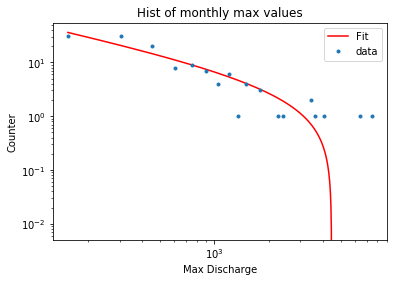

In [54]:
monthly_max_discharge = list(data_sub.groupby(['year','month'],as_index=False).max().Discharge)

hist_mm,bin_edges_mm = np.histogram(monthly_max_discharge,bins=50)


def f_exp(x,A,b,c):
    return A*np.exp(-b*x)+c

def f_powerlaw(x,A,gamma,B):
    return A*x**(-gamma) + B

p0_my=[240,1.5,1]


skip_point = 0
tt = np.linspace(min(bin_edges_mm[1:]),max(bin_edges_mm),300)

popt_mm,pcov_mm = curve_fit(f_powerlaw,bin_edges_mm[skip_point+1:],hist_mm[skip_point:],p0=p0_my)
perr_mm = np.sqrt(np.diag(pcov_mm))
print('A gamma b')
print(popt_mm)
print(perr_mm)
plt.plot(tt,f_powerlaw(tt,*popt_mm),'r-',label='Fit')
plt.plot(bin_edges_mm[1:],hist_mm,'.',label='data')
plt.yscale('log')
plt.xscale('log')
plt.title('Hist of monthly max values')
plt.xlabel('Max Discharge')
plt.ylabel('Counter')
plt.legend()

# Conclusion:

If I choose one month for the time window, the distribution is like a powerlaw. But the maximum values have a similar probability, which means in general there is only one big storm per month.

## Excercise 8

How many time does it rain in a month? Calculate and plot the distribution and fit with an appropriate function.

In [68]:
data_sub_ex7 = data_sub[data_sub.year==2012]
# print(max(list(data_sub_ex7[data_sub_ex7['datetime'].apply(lambda x: x.month ==12)].Discharge)))
data_sub_ex7 = data_sub_ex7.set_index('datetime')
data_sub_ex7 = data_sub_ex7.rolling('30D').count()
data_sub_ex7['datetime'] = data_sub_ex7.index

data_sub_ex7

,Discharge,year,month,day,datetime
datetime,,,,,
2012-01-01 00:00:00,1.0,1.0,1.0,1.0,2012-01-01 00:00:00
2012-01-01 00:15:00,2.0,2.0,2.0,2.0,2012-01-01 00:15:00
2012-01-01 00:30:00,3.0,3.0,3.0,3.0,2012-01-01 00:30:00
2012-01-01 00:45:00,4.0,4.0,4.0,4.0,2012-01-01 00:45:00
2012-01-01 01:00:00,5.0,5.0,5.0,5.0,2012-01-01 01:00:00
...,...,...,...,...,...
2012-12-31 22:45:00,2880.0,2880.0,2880.0,2880.0,2012-12-31 22:45:00
2012-12-31 23:00:00,2880.0,2880.0,2880.0,2880.0,2012-12-31 23:00:00
2012-12-31 23:15:00,2880.0,2880.0,2880.0,2880.0,2012-12-31 23:15:00


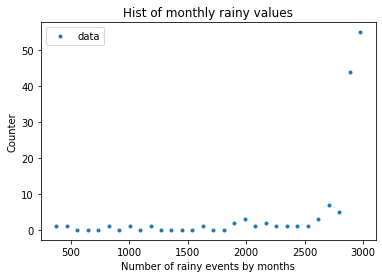

In [72]:
monthly_nr_of_rainy_events = list(data_sub.groupby(['year','month'],as_index=False).count().Discharge)
hist_mc,bin_edges_mc = np.histogram(monthly_nr_of_rainy_events,bins=30)

plt.plot(bin_edges_mc[1:],hist_mc,'.',label='data')
# plt.yscale('log')
# plt.xscale('log')
plt.title('Hist of monthly rainy values')
plt.xlabel('Number of rainy events by months')
plt.ylabel('Counter')
plt.legend()
# def f_exp(x,A,b,c):
#     return A*np.exp(b*x)+c

# # def f_powerlaw(x,A,gamma,B):
# #     return A*x**(-gamma) + B

# def f_const(x,k):
#     return k
# p0_my=[1,0.1,0.05]


# # skip_point = 0
# skip_point_end = 2

# tt = np.linspace(min(bin_edges_mc[1:]),max(bin_edges_mc),300)

# popt_mc,pcov_mc = curve_fit(f_exp,bin_edges_mc[skip_point+1:skip_point_end],hist_mc[:skip_point_end],p0=p0_my)
# perr_mc = np.sqrt(np.diag(pcov_mc))
# print('k')
# print(popt_mc)
# print(perr_mc)
# plt.plot(tt,f_exp(tt,*popt_mc),'r-',label='Fit')
# # plt.plot(bin_edges_mc[1:],hist_mc,'.',label='data')
# # # plt.yscale('log')
# # # plt.xscale('log')
# # plt.title('Hist of monthly max values')
# # plt.xlabel('Discharge')
# # plt.ylabel('Counter')
# # plt.legend()

# Result:
It's like a uniform distribution, with 2 outlier value.

## Excercise 9

Find the measuring station you used in the excercises above on the map. Find another measurement station about 100-200 miles from it and download the data. Try to estimate the typical time it takes for weather fronts to travel the distance between the two measuring stations.